# SIT796 Task 7.1D
Function approximation implementation

Brenton Adey
222165064

## Table of Contents
- [Tile Coding](#tile-coding)
- [Semi-Gradient Sarsa(0)](#semi-gradient-sarsa0)
- [Semi-Gradient TD(λ)](#semi-gradient-tdλ)
- [Comparison](#comparison)

---

In [43]:
import math
import itertools
import glob
from collections import namedtuple

import numpy as np
import matplotlib.pyplot as plt

import gymnasium as gym

from pyvirtualdisplay import Display
from IPython.display import Video

In [23]:
# Initialise Environment
env = gym.make("Acrobot-v1", )

# Tile Coding <a class="anchor" id="tile-coding"></a>

## Create tile coding utility functions

In [3]:
def create_tiling_grid(low, high, bins=(10, 10), offsets=(0.0, 0.0)):
    """Define a uniformly-spaced grid that can be used for tile-coding a space."""
    
    assert len(low)==len(high), "Length of low and high must be the same"
    assert len(low)==len(offsets), "Please provide an offset for every point"
    assert len(low)==len(bins), "Please provide the number of bins for every point"

    # Initialise an empty grid
    grid = []
    
    # For each low, high, and offset value
    for i, (l,h,o) in enumerate(zip(low, high, offsets)):
        
        # Find the length for each tile point
        diff=(h-l)/(bins[i])
        # Create an array of evenly spaced (number of bins)-1 numbers across the feature
        # Note (number of bins)-1 as to not create a tile beginning after the high limit
        grid.append(np.linspace(l+diff,h,bins[i]-1,endpoint=False))
        # Add the offset to the elemets of the array
        grid[-1]+=o
    
    return grid

In [4]:
# Test the function
low = [-1.0, -5.0]
high = [1.0, 5.0]
print(create_tiling_grid(low, high, bins=(10, 10), offsets=(-0.1, 0.5)))

[array([-0.9, -0.7, -0.5, -0.3, -0.1,  0.1,  0.3,  0.5,  0.7]), array([-3.5, -2.5, -1.5, -0.5,  0.5,  1.5,  2.5,  3.5,  4.5])]


In [5]:
def create_tilings(low, high, tiling_specs):
	"""Define multiple tilings using the provided specifications."""
	
	# tiling_specs should be a list of tuples of tuples: [(bins, offsets),(bins, offsets),...,(bins, offsets)]
	tilings=[create_tiling_grid(low, high, ts[0], ts[1]) for ts in tiling_specs]
	
	return tilings

In [6]:
tiling_specs = [((10, 10), (-0.066, -0.33)),
                ((10, 10), (0.0, 0.0)),
                ((10, 10), (0.066, 0.33))]
tilings = create_tilings(low, high, tiling_specs)
print(tilings)

[[array([-0.866, -0.666, -0.466, -0.266, -0.066,  0.134,  0.334,  0.534,
        0.734]), array([-4.33, -3.33, -2.33, -1.33, -0.33,  0.67,  1.67,  2.67,  3.67])], [array([-0.8, -0.6, -0.4, -0.2,  0. ,  0.2,  0.4,  0.6,  0.8]), array([-4., -3., -2., -1.,  0.,  1.,  2.,  3.,  4.])], [array([-0.734, -0.534, -0.334, -0.134,  0.066,  0.266,  0.466,  0.666,
        0.866]), array([-3.67, -2.67, -1.67, -0.67,  0.33,  1.33,  2.33,  3.33,  4.33])]]


## Tile encoding of single sample

In [7]:
def discretize(sample, grid):
    """Discretize a sample as per given grid."""
    return tuple([np.digitize(s,g) for s,g in zip(sample,grid)])

def tile_encode(sample, tilings, flatten=True):
    """Encode given sample using tile-coding.
    Returns
    -------
    encoded_sample : list or array_like
        A list of binary vectors, one for each tiling, or flattened into one.
    """
    if not flatten:
        return [discretize(sample, tile) for tile in tilings]
    
    dimensions = tuple([np.array(tilings).shape[2]+1]*np.array(tilings).shape[1])+(np.array(tilings).shape[0],)
    tiling_size = math.prod(dimensions)

    discretized_array = np.array([discretize(sample, tile) + (idx,) for idx, tile in enumerate(tilings)])
    # Convert into 1D indices
    print(discretized_array)
    tile_indices = np.ravel_multi_index(discretized_array.T,dimensions)
    
    # Create 1D binary array from array of indices
    encoded_sample= np.zeros(tiling_size)
    encoded_sample[tile_indices] = 1
    return encoded_sample

In [8]:
# Test with some sample values
sample = (0.5 , 2)
discretized_sample = tile_encode(sample, tilings, flatten=False)
encoded_sample = tile_encode(sample, tilings)
print("Sample:", repr(sample), sep="\n")
print("\nDiscretized sample:", repr(discretized_sample), sep="\n")
print("\nEncoded sample:", repr(encoded_sample), sep="\n")

[[7 7 0]
 [7 7 1]
 [7 6 2]]
Sample:
(0.5, 2)

Discretized sample:
[(7, 7), (7, 7), (7, 6)]

Encoded sample:
array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 

## Wrap tiling logic in tiling class

Wrap the above functions in a class so it is easy to retrieve values such as number of tilings, number of features, and dimensions

Note, currently only supports tilings of same dimension

In [9]:
class TileCoder:
    """Class for constructing and implementing tile encoding"""
    
    def __init__(self, low, high, tiling_specs, actions=None):
        self._actions = actions
        self.low = low
        self.high = high
        self.tiling_specs = tiling_specs
        self.n_tilings = len(tiling_specs)
        # If control scenario (i.e. mapping state and action space) include number of actions in dimensions (Discrete)
        if actions:
            self.dimensions = tiling_specs[0][0]+(actions.n,)+(self.n_tilings,)
        else:
            self.dimensions = tiling_specs[0][0]+(self.n_tilings,)
        self.n_features = math.prod(self.dimensions)
        self.tilings = self._create_tilings()


    
    def _create_tiling_grid(self, bins, offsets):
        """Define a uniformly-spaced grid that can be used for tile-coding a space."""
        
        assert len(self.low)==len(self.high), "Length of low and high must be the same"
        assert len(self.low)==len(offsets), "Please provide an offset for every point"
        assert len(self.low)==len(bins), "Please provide the number of bins for every point"

        # Initialise an empty grid
        grid = []
        
        # For each low, high, and offset value
        for i, (l,h,o) in enumerate(zip(self.low, self.high, offsets)):
            
            # Find the length for each tile point
            diff=(h-l)/(bins[i])
            # Create an array of evenly spaced (number of bins)-1 numbers across the feature
            # Note (number of bins)-1 as to not create a tile beginning after the high limit
            grid.append(np.linspace(l+diff,h,bins[i]-1,endpoint=False))
            # Add the offset to the elemets of the array
            grid[-1]+=o
        
        return grid
    
    def _create_tilings(self):
        """Define multiple tilings using the provided specifications."""
        
        # tiling_specs should be a list of tuples of tuples: [(bins, offsets),(bins, offsets),...,(bins, offsets)]
        tilings=[self._create_tiling_grid(ts[0], ts[1]) for ts in self.tiling_specs]
        
        return tilings

    def _discretize(self, sample, grid, action):
        """Discretize a sample as per given grid."""
        
        discretized_sample = tuple([np.digitize(s,g) for s,g in zip(sample, grid)])
        
        # If control scenario, include the action in the discretized representation
        if action is not None:
            return discretized_sample + (int(action),)
        else:
            return discretized_sample

    def tile_encode(self, sample, flatten=True):
        """Encode given sample using tile-coding.
        Returns
        -------
        encoded_sample : list or array_like
            A list of binary vectors, one for each tiling, or flattened into one.
        """
        if self._actions:
            action = sample[-1]
            sample = sample[:-1]
        else:
            action = None
        if not flatten:
            return [self._discretize(sample, tile, action) for tile in self.tilings]

        discretized_array = np.array([self._discretize(sample, tile, action) + (idx,) for idx, tile in enumerate(self.tilings)])
        # Convert into 1D indices
        tile_indices = np.ravel_multi_index(discretized_array.T,self.dimensions)
        
        # Create 1D binary array from array of indices
        encoded_sample= np.zeros(self.n_features)
        encoded_sample[tile_indices] = 1
        return encoded_sample

In [10]:
low = [-1.0, -5.0]
high = [1.0, 5.0]
tiling_specs = [((10, 10), (-0.066, -0.33)),
                ((10, 10), (0.0, 0.0)),
                ((10, 10), (0.066, 0.33))]

example_tile_coder = TileCoder(low, high, tiling_specs)

print("Tiling Dimensions: ", example_tile_coder.dimensions)
print("Tilings: ", example_tile_coder.tilings)
print("\n")

sample = (0.5 , 2)
discretized_sample = example_tile_coder.tile_encode(sample, flatten=False)
encoded_sample = example_tile_coder.tile_encode(sample)
print("Sample:", repr(sample), sep="\n")
print("\nDiscretized sample:", repr(discretized_sample), sep="\n")
print("\nEncoded sample:", repr(encoded_sample), sep="\n")

Tiling Dimensions:  (10, 10, 3)
Tilings:  [[array([-0.866, -0.666, -0.466, -0.266, -0.066,  0.134,  0.334,  0.534,
        0.734]), array([-4.33, -3.33, -2.33, -1.33, -0.33,  0.67,  1.67,  2.67,  3.67])], [array([-0.8, -0.6, -0.4, -0.2,  0. ,  0.2,  0.4,  0.6,  0.8]), array([-4., -3., -2., -1.,  0.,  1.,  2.,  3.,  4.])], [array([-0.734, -0.534, -0.334, -0.134,  0.066,  0.266,  0.466,  0.666,
        0.866]), array([-3.67, -2.67, -1.67, -0.67,  0.33,  1.33,  2.33,  3.33,  4.33])]]


Sample:
(0.5, 2)

Discretized sample:
[(7, 7), (7, 7), (7, 6)]

Encoded sample:
array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.

## Apply the tile coding to the state-action space

In [11]:
# Print the state (observation) space
print("State space:", env.observation_space)
print("- low:", env.observation_space.low)
print("- high:", env.observation_space.high)

# Print the action space
print("Action space:", env.action_space)

State space: Box([ -1.        -1.        -1.        -1.       -12.566371 -28.274334], [ 1.        1.        1.        1.       12.566371 28.274334], (6,), float32)
- low: [ -1.        -1.        -1.        -1.       -12.566371 -28.274334]
- high: [ 1.        1.        1.        1.       12.566371 28.274334]
Action space: Discrete(3)


In [12]:
n_bins = 10
bins = tuple([n_bins]*env.observation_space.shape[0])
offset_pos = (env.observation_space.high - env.observation_space.low)/(3*n_bins)

tiling_specs = [(bins, -offset_pos),
                (bins, tuple([0.0]*env.observation_space.shape[0])),
                (bins, offset_pos)]

In [13]:
env_tile_coder = TileCoder(env.observation_space.low, env.observation_space.high, tiling_specs, actions=env.action_space)
print("Dimensions: ",env_tile_coder.dimensions)
print("Number of features: ",env_tile_coder.n_features)

Dimensions:  (10, 10, 10, 10, 10, 10, 3, 3)
Number of features:  9000000


In [14]:
# Test with a random state from the state space
random_state = np.random.uniform(env.observation_space.low,env.observation_space.high)

random_state = np.append(random_state, env.action_space.sample())

print(env_tile_coder.tile_encode(random_state, flatten=False))

encoded_random_state = env_tile_coder.tile_encode(random_state)
print("Indices where 1: ", encoded_random_state.nonzero()[0].tolist())

[(7, 0, 3, 8, 0, 3, 1), (7, 0, 3, 8, 0, 2, 1), (6, 0, 3, 7, 0, 2, 1)]
Indices where 1:  [5433323, 6334222, 6334230]


# Semi-Gradient Sarsa(0) <a class="anchor" id="semi-gradient-sarsa0"></a>

![semi-gradient_sarsa_psuedo_code](./images/semi-gradient_sarsa_psuedo_code.png)

## Build Semi-Gradient Sarsa(0) funtion

In [15]:
def argmax_rand(arr):
    # break ties randomly, np.argmax() always picks first max
    return np.random.choice(np.flatnonzero(arr == np.max(arr)))

In [47]:
class SemiGradientSarsa():

    def __init__(self, env, tile_coder):
        assert tile_coder._actions, "Tile coder must have been initialised with actions for control value estimation"

        self.env = env
        self.tile_coder = tile_coder
        # Initialise weights
        self.weights = np.zeros(tile_coder.n_features)

        self.ExperimentStats = namedtuple("Stats", ["episode_lengths", "episode_rewards"])
        

    def _approximate_q_value(self, state, action):
        
        state_action_pair = np.append(state, action)
        # Featurize the state-action pair to
        encoded_state = self.tile_coder.tile_encode(state_action_pair)
        # Calculate the q value by summing the weights for the active features
        q_value = np.dot(encoded_state, self.weights)

        return q_value

    def _update_weights(self, state, action, delta):
        state_action_pair = np.append(state, action)
        encoded_state = self.tile_coder.tile_encode(state_action_pair)

        self.weights[encoded_state.astype(bool)] += delta

    def _eps_greedy_policy(self, state, eps):
        if np.random.rand() > eps:
            # Select the value which maximises the approximate q function
            q_values = [self._approximate_q_value(state,a) for a in range(env.action_space.start, env.action_space.n)]
            return argmax_rand(q_values)
        else:
            # Otherwise, pick an action at random
            return env.action_space.sample()

    def run_semi_gradient_sarsa(self, n_episodes, gamma, eps, alpha, record_final_episode=False):
        """Run Episodic Semi-Gradient Sarsa"""
        
        stats =  self.ExperimentStats(
            episode_lengths=np.zeros(n_episodes),
            episode_rewards=np.zeros(n_episodes))
        
        # divide step size equally to each tiling
        step_size = alpha / self.tile_coder.n_tilings

        for e in range(n_episodes):
            
            print("Running episode: ", e)
            # If on the last episode, always exploit the policy for recording purposes
            if(e == n_episodes-1 and record_final_episode):
                eps = 0
            
            S = self.env.reset()[0]
            # Get the action based off the current policy
            A = self._eps_greedy_policy(S, eps)

            for t in itertools.count():
                # Take action A and observe reward       
                S_, R, terminated, _, _ = env.step(A)
                stats.episode_rewards[e] += R
                stats.episode_lengths[e] = t
                if terminated:
                    # If terminated calculate the different between the expected reward and actual reward
                    delta = step_size*(R - self._approximate_q_value(S, A))
                    # Update the weights with the delta
                    self._update_weights(S,A,delta)
                    print(f"Episode {e} finished after {t} steps")
                    break
                # If not terminal chose the next action
                A_ = self._eps_greedy_policy(S_, eps)
                # Approximate the value of the next state-action pair
                q_new = self._approximate_q_value(S_, A_)
                # The target is the sum of the actual reward of the current step and the approximated value of the new step
                target = R + gamma * q_new
                delta = step_size*(target - self._approximate_q_value(S, A))
                # Update the difference
                self._update_weights(S,A,delta)
                S, A = S_, A_
        
        return stats
    
    def reset_weights(self):
        self.weights = np.zeros(self.tile_coder.n_features)

## Run and record Sarasa(0) function

In [74]:
print(" \n Animating the last episode")
number_episodes = 100

# Note the *.env at the end, this is to remove the step restriction on the original env
env = gym.make("Acrobot-v1", render_mode="rgb_array").env
env = gym.wrappers.RecordVideo(env,'./vid', episode_trigger=lambda episode_id: episode_id==number_episodes-1)

acrobot_semi_gradient_sarsa = SemiGradientSarsa(env, env_tile_coder)
semi_gradient_sarsa_stats = acrobot_semi_gradient_sarsa.run_semi_gradient_sarsa(
    number_episodes, 0.9, 0.1, 0.5, record_final_episode=True)

files = glob.glob(f'{env.video_folder}/{env.name_prefix}-episode-{number_episodes-1}.mp4')

env.close()

Video(files[0], embed=True)

 
 Animating the last episode
Running episode:  0
Episode 0 finished after 2655 steps
Running episode:  1
Episode 1 finished after 2298 steps
Running episode:  2
Episode 2 finished after 1046 steps
Running episode:  3
Episode 3 finished after 951 steps
Running episode:  4
Episode 4 finished after 1604 steps
Running episode:  5
Episode 5 finished after 1188 steps
Running episode:  6
Episode 6 finished after 680 steps
Running episode:  7
Episode 7 finished after 1650 steps
Running episode:  8
Episode 8 finished after 1823 steps
Running episode:  9
Episode 9 finished after 904 steps
Running episode:  10
Episode 10 finished after 655 steps
Running episode:  11
Episode 11 finished after 560 steps
Running episode:  12
Episode 12 finished after 592 steps
Running episode:  13
Episode 13 finished after 1211 steps
Running episode:  14
Episode 14 finished after 617 steps
Running episode:  15
Episode 15 finished after 358 steps
Running episode:  16
Episode 16 finished after 351 steps
Running episo

Moviepy - Done !
Moviepy - video ready /Users/brenton/Library/CloudStorage/OneDrive-Personal/Documents/_UNIVERSITY/_MASTEROFAI/2023Tri1/SIT796 Reinforcement Learning/7/SIT796-Task7-1D/vid/rl-video-episode-99.mp4
Episode 99 finished after 552 steps


# Semi-Gradient TD(λ) <a class="anchor" id="semi-gradient-tdλ"></a>

![semi-gradient_TD_lambda_psuedo_code](./images/semi-gradient_TDlambda_psuedo_code.png)

## Build semi-gradient TD(λ) functions

In [110]:
class SemiGradientTDLambda():

    def __init__(self, env, tile_coder):
        assert not tile_coder._actions, "Tile coder must have been initialised with no actions for prediction value estimation"

        self.env = env
        self.tile_coder = tile_coder
        # Initialise weights
        self.weights = np.zeros(tile_coder.n_features)

        self.ExperimentStats = namedtuple("Stats", ["episode_lengths", "episode_rewards", "average_state_value"])
        

    def _approximate_value(self, state):
        
        encoded_state = self.tile_coder.tile_encode(state)
        # approximate value by summing the weights of the active features
        v = np.dot(encoded_state, self.weights)

        return v

    def _update_weights(self, state, delta):
        encoded_state = self.tile_coder.tile_encode(state)

        self.weights[encoded_state.astype(bool)] += delta

    def run_semi_gradient_TD_lambda(self, n_episodes, lmbda, gamma, alpha):
        """Run Semi-Gradient TD(λ)"""
        
        stats =  self.ExperimentStats(
            episode_lengths=np.zeros(n_episodes),
            episode_rewards=np.zeros(n_episodes),
            average_state_value=np.zeros(n_episodes))
        
        # divide step size equally to each tiling
        step_size = alpha / self.tile_coder.n_tilings

        for e in range(n_episodes):
            
            print("Running episode: ", e)
            S = self.env.reset()[0]
            # Reset z
            z = np.zeros(self.tile_coder.n_features)

            for t in itertools.count():
                # Take action given state and policy
                A = self.env.action_space.sample()     
                S_, R, terminated, _, _ = env.step(A)
                stats.episode_rewards[e] += R
                stats.episode_lengths[e] = t
                if terminated:
                    print(f"Episode {e} finished after {t} steps")
                    break
                
                # Update eligibility trace
                S_encoded = self.tile_coder.tile_encode(S)
                z *= gamma*lmbda
                # Bump up the eligibility trace
                z[S_encoded.astype(bool)] += 1
                # Update weights
                delta = step_size*(R + gamma*self._approximate_value(S_)-self._approximate_value(S))
                self.weights += delta*z
                
                S = S_
            stats.average_state_value[e] = np.sum(self.weights)/len(self.weights)
            print("Episode average state value: ", stats.average_state_value[e])
        
        return stats
    
    def reset_weights(self):
        self.weights = np.zeros(self.tile_coder.n_features)

## Run and record TD(λ)

In [111]:
env_tile_coder_prediction = TileCoder(env.observation_space.low, env.observation_space.high, tiling_specs)
print("Dimensions: ",env_tile_coder_prediction.dimensions)
print("Number of features: ",env_tile_coder_prediction.n_features)

Dimensions:  (10, 10, 10, 10, 10, 10, 3)
Number of features:  3000000


In [113]:
print(" \n Animating the last episode")
number_episodes = 100

# Note the *.env at the end, this is to remove the step restriction on the original env
env = gym.make("Acrobot-v1").env

acrobot_semi_gradient_TDlambda = SemiGradientTDLambda(env, env_tile_coder_prediction)
semi_gradient_TDlambda_stats = acrobot_semi_gradient_TDlambda.run_semi_gradient_TD_lambda(
    number_episodes, 0.8, 0.9, 0.5)

env.close()

 
 Animating the last episode
Running episode:  0
Episode 0 finished after 1006 steps
Episode average state value:  -0.0005550778951376962
Running episode:  1
Episode 1 finished after 4882 steps
Episode average state value:  -0.0024464367852423136
Running episode:  2
Episode 2 finished after 1273 steps
Episode average state value:  -0.00279457092526009
Running episode:  3
Episode 3 finished after 932 steps
Episode average state value:  -0.0029844469780714164
Running episode:  4
Episode 4 finished after 734 steps
Episode average state value:  -0.003136014472662073
Running episode:  5
Episode 5 finished after 542 steps
Episode average state value:  -0.003316162107463079
Running episode:  6
Episode 6 finished after 4895 steps
Episode average state value:  -0.004209477652323221
Running episode:  7
Episode 7 finished after 1782 steps
Episode average state value:  -0.004561842649664114
Running episode:  8
Episode 8 finished after 1513 steps
Episode average state value:  -0.004716030932450273

# Comparison <a class="anchor" id="comparison"></a>

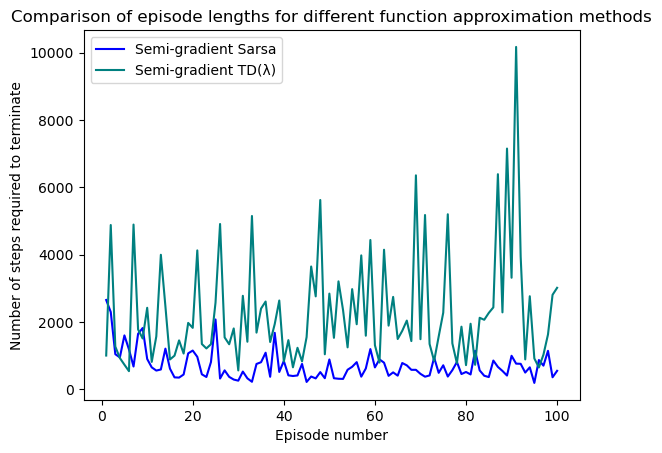

In [119]:
# Analyse of performance over 100 episodes
plt.plot(range(1,101),semi_gradient_sarsa_stats.episode_lengths, label="Semi-gradient Sarsa", c="blue")
plt.plot(range(1,101),semi_gradient_TDlambda_stats.episode_lengths, label="Semi-gradient TD(λ)", c="teal")
plt.title("Comparison of episode lengths for different function approximation methods")
plt.xlabel("Episode number")
plt.ylabel("Number of steps required to terminate")
plt.legend()
plt.show()

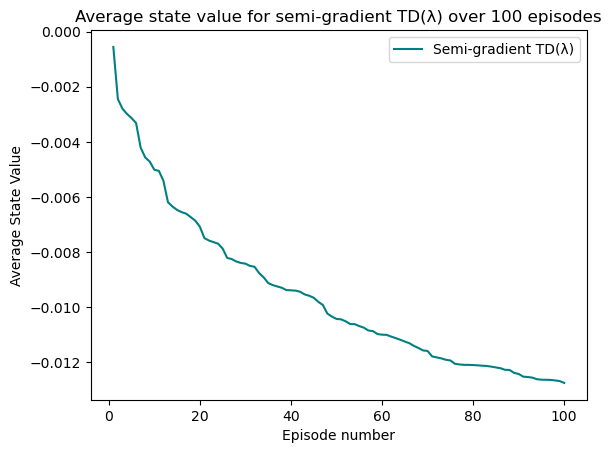

In [120]:
# Analyse of value approximation for semi-gradient TD(λ)
plt.plot(range(1,101),semi_gradient_TDlambda_stats.average_state_value, label="Semi-gradient TD(λ)", c="teal")
plt.title("Average state value for semi-gradient TD(λ) over 100 episodes")
plt.xlabel("Episode number")
plt.ylabel("Average State Value")
plt.legend()
plt.show()